# Introduction

### Problem context
*A manager at the bank is disturbed with more and more customers leaving their credit card services. They would really appreciate if one could predict for them who is gonna get churned so they can proactively go to the customer to provide them better services and turn customers' decisions in the opposite direction.*

### Goal
This notebook aims to try to predict customers who are likely to get churned through Machine Learning algorithms such as Random Forest, AdaBoost and Gradient Boosting.

### Dataset
This dataset consists of 10,000 customers mentioning their age, salary, marital_status, credit card limit, credit card category, etc. There are nearly 18 features. It is an unbalanced dataset where only abouy 16% of customers who have churned.



## Importing Libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns 
import matplotlib.ticker as mtick
import matplotlib.pyplot as plt
import plotly.graph_objs as go
import plotly.express as ex
import plotly.figure_factory as ff
import plotly.offline as offline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import SMOTE 
from sklearn.metrics import accuracy_score
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier

## Data Loading

We load the dataset and have a first look at it.

In [2]:
bank_data = pd.read_csv("../input/credit-card-customers/BankChurners.csv")

# Deleting columns that we do not need (according to "detail" of the data in kaggle.com)
bank_data = bank_data.drop(['Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2', 'Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1',"CLIENTNUM"], axis = 1)

bank_data.head()

,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio
0,Existing Customer,45,M,3,High School,Married,$60K - $80K,Blue,39,5,1,3,12691.0,777,11914.0,1.335,1144,42,1.625,0.061
1,Existing Customer,49,F,5,Graduate,Single,Less than $40K,Blue,44,6,1,2,8256.0,864,7392.0,1.541,1291,33,3.714,0.105
2,Existing Customer,51,M,3,Graduate,Married,$80K - $120K,Blue,36,4,1,0,3418.0,0,3418.0,2.594,1887,20,2.333,0.000
3,Existing Customer,40,F,4,High School,Unknown,Less than $40K,Blue,34,3,4,1,3313.0,2517,796.0,1.405,1171,20,2.333,0.760
4,Existing Customer,40,M,3,Uneducated,Married,$60K - $80K,Blue,21,5,1,0,4716.0,0,4716.0,2.175,816,28,2.500,0.000


In [3]:
bank_data.columns.values

array(['Attrition_Flag', 'Customer_Age', 'Gender', 'Dependent_count',
       'Education_Level', 'Marital_Status', 'Income_Category',
       'Card_Category', 'Months_on_book', 'Total_Relationship_Count',
       'Months_Inactive_12_mon', 'Contacts_Count_12_mon', 'Credit_Limit',
       'Total_Revolving_Bal', 'Avg_Open_To_Buy', 'Total_Amt_Chng_Q4_Q1',
       'Total_Trans_Amt', 'Total_Trans_Ct', 'Total_Ct_Chng_Q4_Q1',
       'Avg_Utilization_Ratio'], dtype=object)

In [4]:
bank_data.isnull().sum()

Attrition_Flag              0
Customer_Age                0
Gender                      0
Dependent_count             0
Education_Level             0
Marital_Status              0
Income_Category             0
Card_Category               0
Months_on_book              0
Total_Relationship_Count    0
Months_Inactive_12_mon      0
Contacts_Count_12_mon       0
Credit_Limit                0
Total_Revolving_Bal         0
Avg_Open_To_Buy             0
Total_Amt_Chng_Q4_Q1        0
Total_Trans_Amt             0
Total_Trans_Ct              0
Total_Ct_Chng_Q4_Q1         0
Avg_Utilization_Ratio       0
dtype: int64

There are no null values, which is good!

## Converting Categorical Features

Next step we convert categorical features to numerical; I decided to use .map() instead of pd.get_dummies().
Also, I decided to group some features as equals, for example, in Marital_Status was either is Married (1) or not (0). Same with Education_Level.


In [5]:
# Make a copy of the original data to use the original one later
num_data = bank_data.copy()

num_data['Attrition_Flag'] = num_data['Attrition_Flag'].map({'Existing Customer':0, 'Attrited Customer':1})
num_data['Income_Category'] = num_data['Income_Category'].map({'Unknown':0, 'Less than $40K':0, '$40K - $60K':1, '$60K - $80K':2, '$80K - $120K':3, '$120K +':4})
num_data['Marital_Status'] = num_data['Marital_Status'].map({'Divorced':0, 'Unknown':0, 'Single':0, 'Married':1})
num_data['Education_Level'] = num_data['Education_Level'].map({'Unknown':0, 'Uneducated':0, 'High School':1, 'College':2,'Graduate':3,'Post-Graduate':4,'Doctorate':5})
num_data['Card_Category'] = num_data['Card_Category'].map({'Blue':0, 'Silver':1, 'Gold':2, 'Platinum':3})

#Just playing with different ways to do the same thing
num_data = pd.get_dummies(num_data) #Gender
num_data.head()

,Attrition_Flag,Customer_Age,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,...,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio,Gender_F,Gender_M
0,0,45,3,1,1,2,0,39,5,1,...,12691.0,777,11914.0,1.335,1144,42,1.625,0.061,0,1
1,0,49,5,3,0,0,0,44,6,1,...,8256.0,864,7392.0,1.541,1291,33,3.714,0.105,1,0
2,0,51,3,3,1,3,0,36,4,1,...,3418.0,0,3418.0,2.594,1887,20,2.333,0.000,0,1
3,0,40,4,1,0,0,0,34,3,4,...,3313.0,2517,796.0,1.405,1171,20,2.333,0.760,1,0
4,0,40,3,0,1,2,0,21,5,1,...,4716.0,0,4716.0,2.175,816,28,2.500,0.000,0,1


## Correlation Heatmap

Getting the correlation of target variable with all the other features.

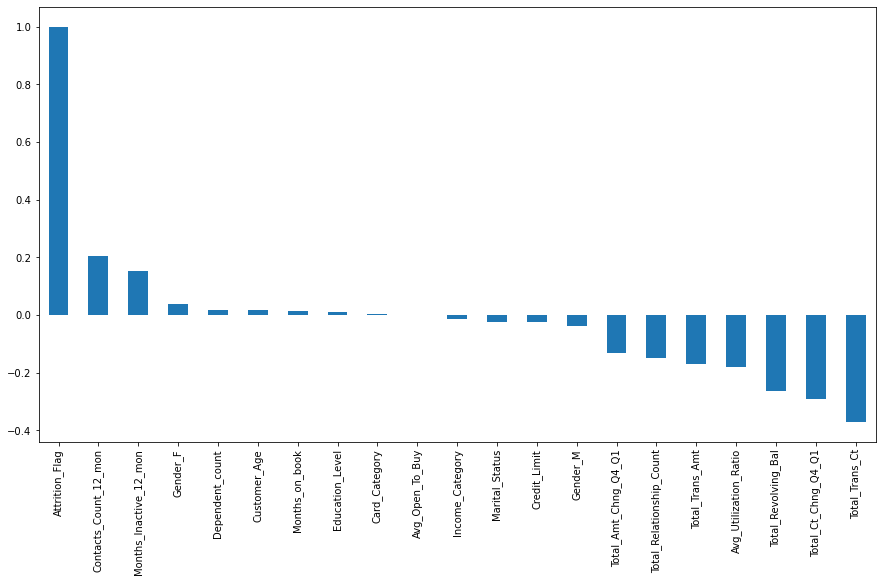

In [6]:
plt.figure(figsize=(15,8))
num_data.corr()["Attrition_Flag"].sort_values(ascending=False).plot(kind="bar")

## Ploting Attrition_Flag

We ca clearly see in this plot the difference between Current Customers and Attritied Customers.

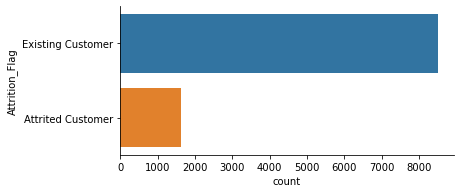

In [7]:
ax = sns.catplot(y="Attrition_Flag", kind="count", data=bank_data, height=2.6, aspect=2.5, orient='h')

## Attrited Customers vs Existing Customers

### By Marital Status

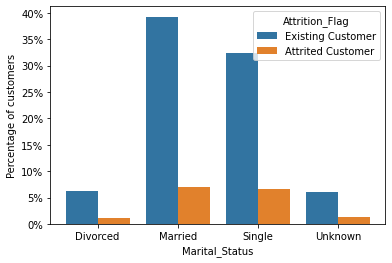

In [8]:
def barplot_percentages(feature, orient='v', axis_name="Percentage of customers"):
    ratios = pd.DataFrame()
    g = bank_data.groupby(feature)["Attrition_Flag"].value_counts().to_frame()
    g = g.rename({"Attrition_Flag": axis_name}, axis=1).reset_index()
    g[axis_name] = g[axis_name]/len(bank_data)
    if orient == 'v':
        ax = sns.barplot(x=feature, y= axis_name, hue='Attrition_Flag', data=g, orient=orient)
        ax.set_yticklabels(['{:,.0%}'.format(y) for y in ax.get_yticks()])
    else:
        ax = sns.barplot(x= axis_name, y=feature, hue='Attrition_Flag', data=g, orient=orient)
        ax.set_xticklabels(['{:,.0%}'.format(x) for x in ax.get_xticks()])
    ax.plot()
barplot_percentages("Marital_Status")

### By Dependant Count

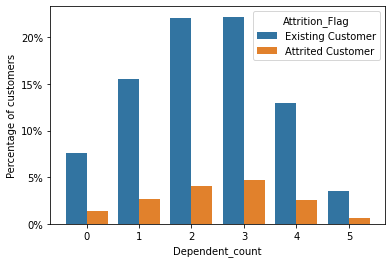

In [9]:
def barplot_percentages(feature, orient='v', axis_name="Percentage of customers"):
    ratios = pd.DataFrame()
    g = bank_data.groupby(feature)["Attrition_Flag"].value_counts().to_frame()
    g = g.rename({"Attrition_Flag": axis_name}, axis=1).reset_index()
    g[axis_name] = g[axis_name]/len(bank_data)
    if orient == 'v':
        ax = sns.barplot(x=feature, y= axis_name, hue='Attrition_Flag', data=g, orient=orient)
        ax.set_yticklabels(['{:,.0%}'.format(y) for y in ax.get_yticks()])
    else:
        ax = sns.barplot(x= axis_name, y=feature, hue='Attrition_Flag', data=g, orient=orient)
        ax.set_xticklabels(['{:,.0%}'.format(x) for x in ax.get_xticks()])
    ax.plot()
barplot_percentages("Dependent_count")

### By Education Level

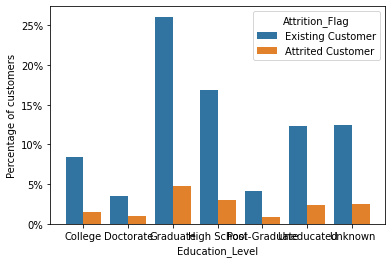

In [10]:
def barplot_percentages(feature, orient='v', axis_name="Percentage of customers"):
    ratios = pd.DataFrame()
    g = bank_data.groupby(feature)["Attrition_Flag"].value_counts().to_frame()
    g = g.rename({"Attrition_Flag": axis_name}, axis=1).reset_index()
    g[axis_name] = g[axis_name]/len(bank_data)
    if orient == 'v':
        ax = sns.barplot(x=feature, y= axis_name, hue='Attrition_Flag', data=g, orient=orient)
        ax.set_yticklabels(['{:,.0%}'.format(y) for y in ax.get_yticks()])
    else:
        ax = sns.barplot(x= axis_name, y=feature, hue='Attrition_Flag', data=g, orient=orient)
        ax.set_xticklabels(['{:,.0%}'.format(x) for x in ax.get_xticks()])
    ax.plot()
barplot_percentages("Education_Level")

## Correlation Heatmap 

In [11]:
corrs = num_data.corr()
figure = ff.create_annotated_heatmap(
    z=corrs.values,
    x=list(corrs.columns),
    y=list(corrs.index),
    annotation_text=corrs.round(2).values,
    showscale=True)
offline.iplot(figure,filename='corrheatmap')

## Features Importances

Next, I will plot the importance of every feature.

For this, I will first remove redundant columns; which means remove columns with 2 unique values.
Then will set Attrition_Flag as my Target Variable (y), to after that use Ranfom Forest to find this features importances.

In [12]:
# # Drop redundant columns and set target variable
# drop = ['Attrition_Flag', 'Gender_F']
# x, y = num_data.drop(drop,axis=1), num_data['Attrition_Flag']

# # Fit RandomForest Classifier
# clf = RandomForestClassifier(n_estimators=350, criterion='entropy', max_features='auto', random_state=1)
# clf = clf.fit(x, y)

# # Plot features importances
# imp = pd.Series(data=clf.feature_importances_, index=x.columns).sort_values(ascending=False)
# plt.figure(figsize=(10,12))
# plt.title("Feature importance")
# ax = sns.barplot(y=imp.index, x=imp.values, palette="Blues_d")

## Data Preprocessing

### Dividing Dataset
We divide into label and feature sets

In [13]:
X = num_data.drop(['Attrition_Flag'], axis = 1) # Features
Y = num_data['Attrition_Flag'] # Labels
print(type(X))
print(type(Y))
print(X.shape)
print(Y.shape)

<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.series.Series'>
(10127, 20)
(10127,)


### Normalizing
Next, we normalize numerical so that each feature has mean 0 and variance 1 using Standar Scaler.

In [14]:
feature_scaler = StandardScaler()
X_scaled = feature_scaler.fit_transform(X)

### Dividing Dataset 
Now we divide into training and test sets

In [15]:
X_train, X_test, Y_train, Y_test = train_test_split( X_scaled, Y, test_size = 0.3, random_state = 100)

print(X_train.shape)
print(X_test.shape)

(7088, 20)
(3039, 20)


## Implementing Oversampling 
To balance the dataset we use SMOTE which stands for Synthetic Minority Oversampling Technique.

In [16]:
print("Number of observations in each class before oversampling (training data): \n", pd.Series(Y_train).value_counts())

smote = SMOTE(random_state = 101)
X_train,Y_train = smote.fit_sample(X_train,Y_train)

print("Number of observations in each class after oversampling (training data): \n", pd.Series(Y_train).value_counts())

Number of observations in each class before oversampling (training data): 
 0    5984
1    1104
Name: Attrition_Flag, dtype: int64
Number of observations in each class after oversampling (training data): 
 1    5984
0    5984
Name: Attrition_Flag, dtype: int64


# Random Forest Classifier

### Tuning Random Forest

Now, we will find the best parameters to run Random Forest and implementing cross-validation using Grid Search.

In the GridSearch parameters we use "recall" as in this case I will be trying to reduce False Negatives.


In [17]:
rfc = RandomForestClassifier(criterion='entropy', max_features='auto', random_state=1)
grid_param = {'n_estimators': [200, 250, 300, 350, 400, 450]}

gd_sr = GridSearchCV(estimator=rfc, param_grid=grid_param, scoring='recall', cv=5)

gd_sr.fit(X_train, Y_train)

best_parameters = gd_sr.best_params_
print(best_parameters)

best_result = gd_sr.best_score_ # Mean cross-validated score of the best_estimator
print(best_result)


{'n_estimators': 350}
0.9822869604334136


### Building Random Forest

We build now our Random Forest using the tuned parameter (350 number of trees in the forest).
Also, we plot a Confusion Matrix to appreciate better the results.



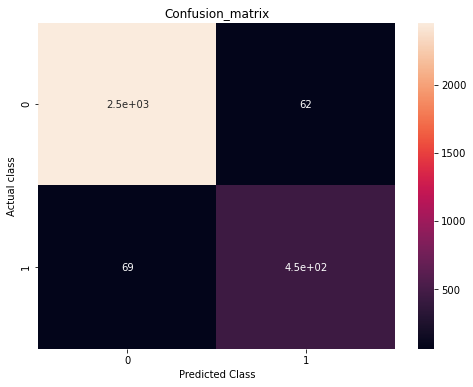

Confusion matrix: 
 [[2454   62]
 [  69  454]]
TP:  454
TN:  2454
FP:  62
FN:  69


In [18]:
rfc = RandomForestClassifier(n_estimators=350, criterion='entropy', max_features='auto', random_state=1)
rfc.fit(X_train,Y_train)

Y_pred = rfc.predict(X_test)

conf_mat = metrics.confusion_matrix(Y_test, Y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(conf_mat,annot=True)
plt.title("Confusion_matrix")
plt.xlabel("Predicted Class")
plt.ylabel("Actual class")
plt.show()
print('Confusion matrix: \n', conf_mat)
print('TP: ', conf_mat[1,1])
print('TN: ', conf_mat[0,0])
print('FP: ', conf_mat[0,1])
print('FN: ', conf_mat[1,0])

In [19]:
print(metrics.classification_report(Y_test,rfc.predict(X_test)))
print('Accuracy_Score:',accuracy_score(Y_test,Y_pred)*100,'%')
print('Recall:',metrics.recall_score(Y_test,Y_pred)*100,'%')

              precision    recall  f1-score   support

           0       0.97      0.98      0.97      2516
           1       0.88      0.87      0.87       523

    accuracy                           0.96      3039
   macro avg       0.93      0.92      0.92      3039
weighted avg       0.96      0.96      0.96      3039

Accuracy_Score: 95.68937150378414 %
Recall: 86.80688336520076 %


### Finding Feature Importances

Now we look for the features with higher importance, to run a new Random Forest using only some of the most important ones.

In [20]:
featimp = pd.Series(rfc.feature_importances_, index=list(X)).sort_values(ascending=False)
print(featimp)

Total_Trans_Ct              0.199107
Total_Trans_Amt             0.185699
Total_Revolving_Bal         0.096375
Total_Ct_Chng_Q4_Q1         0.089616
Total_Relationship_Count    0.064225
Months_Inactive_12_mon      0.051462
Total_Amt_Chng_Q4_Q1        0.051178
Avg_Utilization_Ratio       0.047992
Contacts_Count_12_mon       0.043492
Avg_Open_To_Buy             0.029482
Credit_Limit                0.027560
Customer_Age                0.027085
Months_on_book              0.021133
Dependent_count             0.017958
Income_Category             0.013966
Education_Level             0.012431
Marital_Status              0.008140
Gender_M                    0.005445
Gender_F                    0.005066
Card_Category               0.002589
dtype: float64


### Selecting features with higher significance

Now we will create a new subset (X1), using only some features, and run a new Random Forest to compare them.

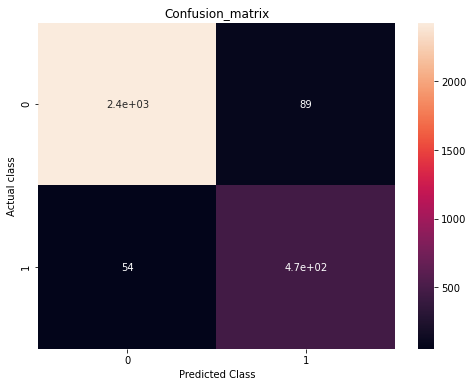

Confusion matrix: 
 [[2427   89]
 [  54  469]]
TP:  469
TN:  2427
FP:  89
FN:  54


In [21]:
X1 = num_data[['Total_Trans_Ct', 'Total_Trans_Amt', 'Total_Revolving_Bal', 'Total_Ct_Chng_Q4_Q1', 'Total_Relationship_Count',
                 'Months_Inactive_12_mon','Total_Amt_Chng_Q4_Q1']]

feature_scaler = StandardScaler()
X1_scaled = feature_scaler.fit_transform(X1)

X1_train, X1_test, Y1_train, Y1_test = train_test_split( X1_scaled, Y, test_size = 0.3, random_state = 100)

smote = SMOTE(random_state = 101)
X1_train,Y1_train = smote.fit_sample(X1_train,Y1_train)

rfc = RandomForestClassifier(n_estimators=350, criterion='entropy', max_features='auto', random_state=1)
rfc.fit(X1_train,Y1_train)

Y_pred = rfc.predict(X1_test)

conf_mat = metrics.confusion_matrix(Y1_test, Y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(conf_mat,annot=True)
plt.title("Confusion_matrix")
plt.xlabel("Predicted Class")
plt.ylabel("Actual class")
plt.show()
print('Confusion matrix: \n', conf_mat)
print('TP: ', conf_mat[1,1])
print('TN: ', conf_mat[0,0])
print('FP: ', conf_mat[0,1])
print('FN: ', conf_mat[1,0])



In [22]:
print(metrics.classification_report(Y1_test,Y_pred))
print('Accuracy_Score:',accuracy_score(Y1_test,Y_pred)*100,'%')
print('Recall:',metrics.recall_score(Y1_test,Y_pred)*100,'%')

              precision    recall  f1-score   support

           0       0.98      0.96      0.97      2516
           1       0.84      0.90      0.87       523

    accuracy                           0.95      3039
   macro avg       0.91      0.93      0.92      3039
weighted avg       0.95      0.95      0.95      3039

Accuracy_Score: 95.29450477130635 %
Recall: 89.67495219885278 %


# AdaBoost Classifier


### Tuning AdaBoost

Same as with Random Forest, we will try to find the best parameters to run now AdaBoost, implementing cross-validation using Grid Search.

In [23]:
abc = AdaBoostClassifier(random_state=1)
grid_param = {'n_estimators': [5,10,20,30,40,50]}

gd_sr = GridSearchCV(estimator=abc, param_grid=grid_param, scoring='recall', cv=5)

gd_sr.fit(X_train, Y_train)

best_parameters = gd_sr.best_params_
print(best_parameters)

best_result = gd_sr.best_score_ # Mean cross-validated score of the best_estimator
print(best_result)


{'n_estimators': 50}
0.9513734168196409


### Building AdaBoost

After running GridSearch we found that the ideal maximum number of estimators at which boosting is terminatedo is 50 so we now build our AdaBoost Classifier using the this parameter and then we plot a Confusion Matrix to appreciate better the results.



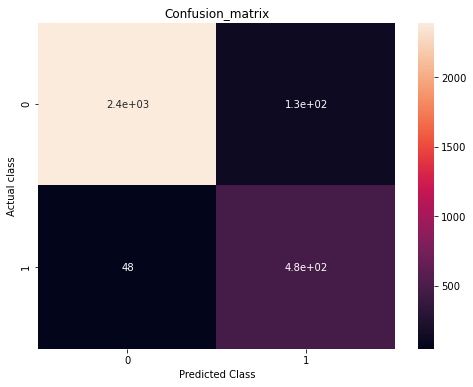

Confusion matrix: 
 [[2390  126]
 [  48  475]]
TP:  475
TN:  2390
FP:  126
FN:  48


In [24]:
abc = AdaBoostClassifier(n_estimators=50, random_state=1)
abc.fit(X_train,Y_train)

Y_pred = abc.predict(X_test)

conf_mat = metrics.confusion_matrix(Y_test, Y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(conf_mat,annot=True)
plt.title("Confusion_matrix")
plt.xlabel("Predicted Class")
plt.ylabel("Actual class")
plt.show()
print('Confusion matrix: \n', conf_mat)
print('TP: ', conf_mat[1,1])
print('TN: ', conf_mat[0,0])
print('FP: ', conf_mat[0,1])
print('FN: ', conf_mat[1,0])

In [25]:
print('Classification report: \n', metrics.classification_report(Y_test, Y_pred))
print('Accuracy_Score:',accuracy_score(Y_test, Y_pred)*100,'%')
print('Recall:',metrics.recall_score(Y_test, Y_pred)*100,'%')


Classification report: 
               precision    recall  f1-score   support

           0       0.98      0.95      0.96      2516
           1       0.79      0.91      0.85       523

    accuracy                           0.94      3039
   macro avg       0.89      0.93      0.91      3039
weighted avg       0.95      0.94      0.94      3039

Accuracy_Score: 94.27443237907205 %
Recall: 90.82217973231359 %


### Feature Importances

In [26]:
featimp = pd.Series(abc.feature_importances_, index=list(X)).sort_values(ascending=False)
print(featimp)

Total_Trans_Amt             0.26
Total_Trans_Ct              0.20
Contacts_Count_12_mon       0.08
Dependent_count             0.08
Months_Inactive_12_mon      0.08
Total_Revolving_Bal         0.06
Total_Relationship_Count    0.04
Customer_Age                0.04
Total_Amt_Chng_Q4_Q1        0.04
Total_Ct_Chng_Q4_Q1         0.04
Avg_Open_To_Buy             0.02
Credit_Limit                0.02
Income_Category             0.02
Marital_Status              0.02
Gender_F                    0.00
Months_on_book              0.00
Card_Category               0.00
Education_Level             0.00
Avg_Utilization_Ratio       0.00
Gender_M                    0.00
dtype: float64


# Gradient Boosting Classifier

### Tuning Gradient Boosting

Last, we do the same thing to find the best parameters to run now Gradient Boosting, implementing cross-validation using Grid Search.

In [27]:
gbc = GradientBoostingClassifier(random_state=1)
grid_param = {'n_estimators': [10,20,30,40,50], 'max_depth': [5,6,7,8,9,10,11,12], 'max_leaf_nodes': [8,12,16,20,24,28,32]}

gd_sr = GridSearchCV(estimator=gbc, param_grid=grid_param, scoring='recall', cv=5)

gd_sr.fit(X_train, Y_train)

best_parameters = gd_sr.best_params_
print(best_parameters)

best_result = gd_sr.best_score_ # Mean cross-validated score of the best_estimator
print(best_result)


{'max_depth': 9, 'max_leaf_nodes': 32, 'n_estimators': 40}
0.9689197911165873


### Building Gradient Boosting

Now we run Gradient Boosting Classifier using the tuned parameters which are n_estimators=40, max_depth=9 and max_leaf_nodes=32 and we plot a Confusion Matrix.



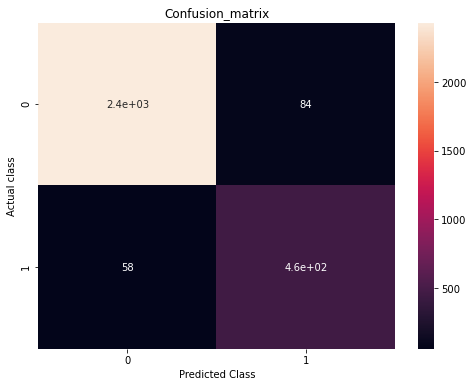

Confusion matrix: 
 [[2432   84]
 [  58  465]]
TP:  465
TN:  2432
FP:  84
FN:  58


In [28]:
# Building Gradient Boost using the tuned parameter
gbc = GradientBoostingClassifier(n_estimators=40, max_depth=9, max_leaf_nodes=32, random_state=1)
gbc.fit(X_train,Y_train)

Y_pred = gbc.predict(X_test)
# print('Classification report: \n', metrics.classification_report(Y_test, Y_pred))

conf_mat = metrics.confusion_matrix(Y_test, Y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(conf_mat,annot=True)
plt.title("Confusion_matrix")
plt.xlabel("Predicted Class")
plt.ylabel("Actual class")
plt.show()
print('Confusion matrix: \n', conf_mat)
print('TP: ', conf_mat[1,1])
print('TN: ', conf_mat[0,0])
print('FP: ', conf_mat[0,1])
print('FN: ', conf_mat[1,0])


In [29]:
print('Classification report: \n', metrics.classification_report(Y_test, Y_pred))
print('Accuracy_Score:',accuracy_score(Y_test, Y_pred)*100,'%')
print('Recall:',metrics.recall_score(Y_test, Y_pred)*100,'%')

Classification report: 
               precision    recall  f1-score   support

           0       0.98      0.97      0.97      2516
           1       0.85      0.89      0.87       523

    accuracy                           0.95      3039
   macro avg       0.91      0.93      0.92      3039
weighted avg       0.95      0.95      0.95      3039

Accuracy_Score: 95.32741033234616 %
Recall: 88.91013384321224 %


### Feature Importances

In [30]:
featimp = pd.Series(gbc.feature_importances_, index=list(X)).sort_values(ascending=False)
print(featimp)

Total_Trans_Ct              0.489554
Total_Trans_Amt             0.146406
Total_Revolving_Bal         0.102765
Total_Relationship_Count    0.076267
Total_Ct_Chng_Q4_Q1         0.062811
Months_Inactive_12_mon      0.036911
Total_Amt_Chng_Q4_Q1        0.024641
Contacts_Count_12_mon       0.017603
Customer_Age                0.016237
Avg_Open_To_Buy             0.006714
Credit_Limit                0.004660
Months_on_book              0.003624
Dependent_count             0.003423
Marital_Status              0.003259
Avg_Utilization_Ratio       0.001944
Education_Level             0.001109
Income_Category             0.000719
Gender_F                    0.000545
Gender_M                    0.000438
Card_Category               0.000372
dtype: float64


# Conclusion

I decided to work keeping the classifier with the highest possible recall score, this in order to get a minimum number of False Negatives, the reason of this is because those False Negatives are basically customers that our model is predicting that are still "Existing Customers" but the reality is that they are "Attrited Customers". 
In other words, this are customers that we think they still are with us, but the actually have already churned. In this kind of situations it is better to try to reduce this Falses Predictions, because the other ones, the False Positives, are customers we are not expecting to be with us and however they are, which means we have more customers than expected.
__________

We could see that AdaBoost Classifier was the one which has performed better; even though the accuracy score was a little lower than the other models it got a recall score of 90.82 (higher than all the other models) which helps in having only 48 False Negatives.

